# Jaccard and RBO Comparison 
To understand the magnatude of changes to your query result sets, you can compare multiple snapshots to each other.

This notebook provides both Jaccard and Rank Biased Overlap (RBO) metrics.

Please copy this example and customize it for your own purposes!

In [1]:
from js import fetch
from typing import List, Optional, Union

import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import piplite
await piplite.install('seaborn')
await piplite.install('rbo')

import rbo
import seaborn as sns

import os

In [2]:
# Generic GET call to a JSON endpoint 
async def get_json(url):
    resp = await fetch(url)
    resp_text = await resp.text()
    return json.loads(resp_text)

In [3]:
# Basic Quepid API client methods

async def get_snapshots(case):
    response = await get_json(f'/api/cases/{case}/snapshots?shallow=true')
    return [{'id': snapshot['id'], 'name': snapshot['name']} for snapshot in response['snapshots']]

async def get_cases_with_snapshots():
    cases = await get_cases()
    cases_with_snapshots = [{
        'id': case['id'],
        'name': case['name'],
        'snapshots': [ {
            'id': snapshot['id'],
            'name': snapshot['name']
        } for snapshot in (await get_snapshots(case['id'])) ]
    } for case in cases]
    return cases_with_snapshots


In [4]:
# Load snapshot, return dict of queries and their (number of results, avg. score, [doc ids])
async def load_snapshot(case_id, snapshot_id):
    snapshot = await get_json(f'/api/cases/{case_id}/snapshots/{snapshot_id}')
    docs = snapshot['docs']
    queries = snapshot['queries']
    
    # scores are a list of dicts, group them by query
    scores_list = snapshot['scores']
    scores = {}
    for scores_dict in scores_list:
        scores[scores_dict['query_id']] = scores_dict
        
    return pd.DataFrame({
            "num_results": [scores[query['query_id']]['number_of_results'] for query in queries],
            "score": [scores[query['query_id']]['score'] for query in queries],
            "docs": [[doc['id'] for doc in docs[str(query['query_id'])] if doc['rated_only'] == False] for query in queries]
        },
        index=pd.Series(name='query', data=[query['query_text'] for query in queries])
    )

await load_snapshot(case_id=6789, snapshot_id=2471)

,num_results,score,docs
query,,,
projector screen,1,1.0,"[1069226, 47471, 490523, 1229109, 1229118, 325..."
notebook,1,1.0,"[3851056, 3959000, 1550833, 1684763, 1675257, ..."
iphone 8,1,1.0,"[2048598, 1648546, 79524888, 1857711, 3613408,..."
printer,1,1.0,"[3849563, 2225354, 1569761, 798960, 377837, 13..."
computer,1,1.0,"[560468, 532095, 560475, 523407, 693956, 56047..."
...,...,...,...
windows 10,1,1.0,"[4481689, 3902727, 1560529, 1797902, 3155116, ..."
microwave,1,1.0,"[79513345, 4020048, 1768856, 2936032]"
bluetooth speakers,1,1.0,"[1993197, 3537784, 279672, 2663204, 558184, 33..."


In [5]:
os.environ["TQDM_DISABLE"] = "1"

In [6]:
def jaccard(l1, l2, max_n):
    if len(l1) == 0 and len(l2) == 0:
        return 1
    max_len = min(len(l1), len(l2), max_n)
    set1 = set(l1[:max_len])
    set2 = set(l2[:max_len])
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return float(intersection) / union

async def load_snapshots(case_id1, snapshot_id1, case_id2, snapshot_id2):
    df_a = await load_snapshot(case_id1, snapshot_id1)
    df_b = await load_snapshot(case_id2, snapshot_id2)
    return df_a.merge(df_b, on='query')

async def compare(case_id1, snapshot_id1, case_id2, snapshot_id2):
    df = await load_snapshots(case_id1, snapshot_id1, case_id2, snapshot_id2)
    
    df['jaccard'] = df.apply(lambda row: jaccard(row['docs_x'], row['docs_y'], 10), axis=1)
    df['rbo'] = df.apply(lambda row: rbo.RankingSimilarity(row['docs_x'], row['docs_y']).rbo(), axis=1)
    df['score_delta'] = df['score_y'] - df['score_x']
    df.name = f"Case {case_id1} snapshot {snapshot_id1} vs. case {case_id1} snapshot {snapshot_id2}"
    return df



await compare(case_id1=6789, snapshot_id1=2471, case_id2=6789, snapshot_id2=2472)

/lib/python3.11/site-packages/rbo/rbo.py:129: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  for d in tqdm(range(1, k), disable=~self.verbose):


,num_results_x,score_x,docs_x,num_results_y,score_y,docs_y,jaccard,rbo,score_delta
query,,,,,,,,,
projector screen,1,1.0,"[1069226, 47471, 490523, 1229109, 1229118, 325...",1,1.0,"[1069226, 47471, 490523, 1229109, 1229118, 325...",1.0,1.0,0.0
notebook,1,1.0,"[3851056, 3959000, 1550833, 1684763, 1675257, ...",1,1.0,"[3851056, 3959000, 1550833, 1684763, 1675257, ...",1.0,1.0,0.0
iphone 8,1,1.0,"[2048598, 1648546, 79524888, 1857711, 3613408,...",1,1.0,"[2048598, 1648546, 79524888, 1857711, 3613408,...",1.0,1.0,0.0
printer,1,1.0,"[3849563, 2225354, 1569761, 798960, 377837, 13...",1,1.0,"[3849563, 2225354, 1569761, 798960, 377837, 13...",1.0,1.0,0.0
computer,1,1.0,"[560468, 532095, 560475, 523407, 693956, 56047...",1,1.0,"[560468, 532095, 560475, 523407, 693956, 56047...",1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
windows 10,1,1.0,"[4481689, 3902727, 1560529, 1797902, 3155116, ...",1,1.0,"[4481689, 3902727, 1560529, 1797902, 3155116, ...",1.0,1.0,0.0
microwave,1,1.0,"[79513345, 4020048, 1768856, 2936032]",1,1.0,"[79513345, 4020048, 1768856, 2936032]",1.0,1.0,0.0
bluetooth speakers,1,1.0,"[1993197, 3537784, 279672, 2663204, 558184, 33...",1,1.0,"[1993197, 3537784, 279672, 2663204, 558184, 33...",1.0,1.0,0.0


In [7]:
import matplotlib
matplotlib.rc_file_defaults()

def plot_compare(df):
    figure, axes = plt.subplots(1, 3, figsize=(10, 4))
    figure.suptitle(df.name)

    sns.barplot(ax=axes[0], x=df['score_delta'], y=df.index, width=0.3, color='darkgrey')
    axes[0].set(xlim=(-1, 1))
    axes[0].set_xlabel('Change in Score')
    axes[0].set_ylabel('')
    axes[0].set_facecolor((0.90, 0.90, 0.90))
    axes[0].grid(True)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['bottom'].set_visible(False)
    axes[0].spines['left'].set_visible(False)
    axes[0].set_axisbelow(True)
    axes[0].xaxis.grid(color='w', linestyle='solid')
    axes[0].yaxis.grid(color='w', linestyle='solid')
    
    sns.heatmap(df[['jaccard']], ax=axes[1], cmap='crest', annot=True, xticklabels=False, yticklabels=False)
    axes[1].set_xlabel('Jaccard Similiarity')
    axes[1].set_ylabel('')
    
    sns.heatmap(df[['rbo']], ax=axes[2], cmap='crest', annot=True, xticklabels=False, yticklabels=False)
    axes[2].set_xlabel('Rank Biased Overlap')
    axes[2].set_ylabel('')
    
    plt.show()
    
df = await compare(case_id1=6789, snapshot_id1=2471, case_id2=6789, snapshot_id2=2473)


## Overall Jaccard and RBO Scores

In [8]:
print(f"Overall Jaccard Score: {df['jaccard'].mean()}\nOverall RBO Score: {df['rbo'].mean()}")

Overall Jaccard Score: 1.0
Overall RBO Score: 1.0


## Query Level Jaccard and RBO Scores

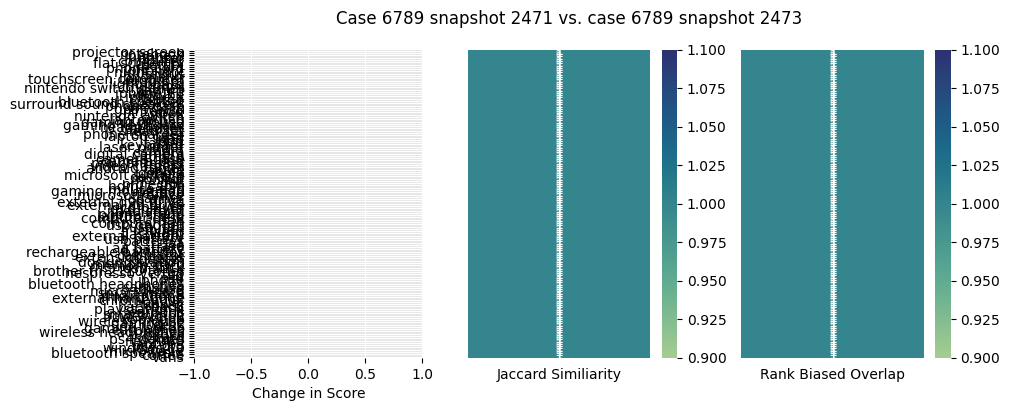

In [9]:
plot_compare(df)

_This notebook was last updated 19-FEB-2024_